# Population, GDP, GDP_Debt Processing
## Data Normalization and Imputing Values

__goal__ is to normalize BRI data (aggregated by year and country) by three additional variables:    
- population    
- GDP      
- debt to GDP   

------

our time range spreads over the past 20 years and significant growth (or changes) in these areas should be identified within the normalization metrics   

it is nessecary to view normalization over individual years to allow for accurate aggregation when we take into account this temporal component    

the following documentation showcases the sparsity of the data, imputation for gdp_debt data, and normalization of point data

-------

We will also impute missing data for GDP and GDP_Debt in the years 1990 through 2020. 

In [1]:
import pandas as pd
import numpy as np

import os
import json

import matplotlib.pyplot as plt
import datetime as datetime

from scipy.stats import linregress

#### Import in Data Sets to Transform

In [2]:
git_repo_loc = os.path.dirname(os.path.realpath("Data Normalization.ipynb"))

pop = pd.read_csv(git_repo_loc + "/Population.csv", )
gdp = pd.read_csv(git_repo_loc + "/GDP.csv")
gdp_debt = pd.read_csv(git_repo_loc + "/GDP_Debt.csv")
# The field GDP Debt Use Value includes the most recent year of debt data

In [3]:
# transform country naming conventions to match expectations 
def load_dict(path): 
    file = open(path, "r")
    contents = file.read()
    dictionary = json.loads(contents)
    file.close()
    return dictionary

# move to common naming conventions
recipient_mapping = load_dict("../country_config.txt")
pop['Country Name'] = pop['Country Name'].replace(recipient_mapping)
gdp['Country Name'] = gdp['Country Name'].replace(recipient_mapping)
gdp_debt['Country Name'] = gdp_debt['Country Name'].replace(recipient_mapping)

#### Import in Country data set 

Ensure common naming conventions and remove un-qualified countries.

In [4]:
countries = pd.read_csv("../../data_final/countries.csv")

In [5]:
pop = pop.merge(countries, right_on='country', left_on='Country Name', how='left')

# drop unneeded columns, rename country name columns
pop.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code', 'name', 'country', 'geometry', 'iso', 'shape_length', 'shape_area'], inplace=True)
pop.rename(columns={'Country Name':'country'}, inplace=True)

pop = pop[pop['country'] != 'Not classified'].reset_index(drop=True)

In [6]:
gdp = gdp.merge(countries, right_on='country', left_on='Country Name', how='left')

# drop unneeded columns, rename country name columns
gdp.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code', 'name', 'country', 'geometry', 'iso', 'shape_length', 'shape_area'], inplace=True)
gdp.rename(columns={'Country Name':'country'}, inplace=True)

gdp = gdp[(gdp['country'] != 'Not classified') & (gdp['country'] != 'World')].reset_index(drop=True)

In [7]:
gdp_debt = gdp_debt.merge(countries, right_on='country', left_on='Country Name', how='left')

# drop unneeded columns, rename country name columns
gdp_debt.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code', 'name', 'country', 'geometry', 'iso', 'shape_length', 'shape_area'], inplace=True)
gdp_debt.rename(columns={'Country Name':'country'}, inplace=True)

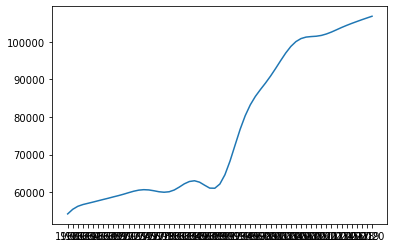

In [8]:
plt.plot(pop.drop(columns=['country', 'country_id']).iloc[0].index, pop.drop(columns=['country', 'country_id']).iloc[0].values)

## 1) Determine gaps in Data 

We know we are going to have to impute some of this data. Let's first see how accurate we can predict our results to be. 

Note: 
- prop : proportion of countries who have data in the year out of all countries 

In [9]:
dfs = [pop, gdp, gdp_debt]
labels = ['year', 'Pop prop', 'GDP prop', 'GDP_Debt prop']
proportions = pd.DataFrame(columns=['year'])
proportions['year'] = range(1960, 2021)
proportions['year'] = proportions['year'].astype(str)
proportions.set_index('year')

# for each year, 
# what is the proportion of gdp_debt/gdp/population values available out of the countries that actually have data for that year

for x in range(0, len(dfs)):
    # restrict to countries that have been found in common dataset 
    temp_r = dfs[x][pd.notna(dfs[x]['country_id'])].drop(columns=['country', 'country_id'])

    # calculate percent available values across all countries for a given year 
    p = (temp_r.notna().sum() * 100 / len(countries)).to_frame().reset_index().rename(columns={'index':'year', 0:labels[1+x]})
    proportions = proportions.merge(p, on='year', how='left')

In [10]:
print("These are the percents of countries with data available for a given year.")
proportions[-50:]

These are the percents of countries with data available for a given year.


,year,Pop prop,GDP prop,GDP_Debt prop
11,1971,85.2,49.2,NaN
12,1972,85.2,49.2,NaN
13,1973,85.2,49.2,NaN
14,1974,85.2,49.6,NaN
15,1975,85.2,50.4,NaN
16,1976,85.2,50.8,NaN
17,1977,85.2,52.0,NaN
18,1978,85.2,51.6,NaN
19,1979,85.2,52.0,NaN
20,1980,85.2,56.4,NaN


## 2) Transform Datasets to be panel data

This means instead of "country", 2000, 2001, 2002, ... as columns. We have year, country, population. 

## 3 ) Impute Missing data w/ Time Interpolation

In [11]:
pop2 = pop.set_index(['country', 'country_id'])
pop2 = pop2.stack(dropna=False).to_frame()
pop2 = pop2.reset_index().rename(columns={'level_2':'year', 0:'population'})

In [12]:
pop2.year = pd.to_datetime(pop2.year, format='%Y')
pop2 = pop2.set_index('year')

pop3 = pop2.groupby(['country', 'country_id']).apply(lambda group: group.population.interpolate(method='time'))
pop3 = pop3.stack(dropna=False).to_frame().reset_index().rename(columns={0: 'population'})

In [13]:
gdp2 = gdp.set_index(['country', 'country_id'])
gdp2 = gdp2.stack(dropna=False).to_frame()
gdp2 = gdp2.reset_index().rename(columns={'level_2':'year', 0:'gdp'})

In [14]:
gdp2.year = pd.to_datetime(gdp2.year, format='%Y')
gdp2 = gdp2.set_index('year')

gdp3 = gdp2.groupby(['country', 'country_id']).apply(lambda group: group.gdp.interpolate(method='time'))
gdp3 = gdp3.stack(dropna=False).to_frame().reset_index().rename(columns={0: 'gdp'})

In [15]:
debt = gdp_debt.set_index(['country', 'country_id'])
debt = debt.stack(dropna=False).to_frame()
debt = debt.reset_index().rename(columns={'level_2':'year', 0:'gdp_debt'})

In [16]:
debt.year = pd.to_datetime(debt.year, format='%Y')
debt = debt.set_index('year')

debt2 = debt.groupby(['country', 'country_id']).apply(lambda group: group['gdp_debt'].interpolate(method='time'))
debt2 = debt2.stack(dropna=False).to_frame().reset_index().rename(columns={0: 'gdp_debt'})

## 4) Group into one Panel Data set 

In [17]:
panel = pop2.merge(gdp2, on=['country', 'country_id', 'year'], how='outer')
panel = panel.merge(debt, on=['country', 'country_id', 'year'], how='outer').reset_index()

In [18]:
# move years back to solid year 
panel['year'] = [str(x).split('-')[0] for x in panel['year']]

In [19]:
panel.to_csv("../../data_final/world_stats.csv")